In [2]:
import os; os.chdir("..")

In [3]:
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import pytorch_lightning as pl

# utils packages
from torchmetrics.regression import MeanAbsolutePercentageError
from sklearn.preprocessing import MinMaxScaler

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

from ncps.torch import LTC
from ncps.wirings import AutoNCP


import project.utils as utils
from project.model import SequenceLearner
from run import read_data
from config import Config

In [4]:
device = "cpu" 

In [46]:
# create dataset for evaluation
data_raw = read_data(Config.PATH)
data_raw = utils.prepare_data(data_raw, station=Config.STATION, features=Config.FEATURES_LIST)
min_value, max_value = data_raw.value.min(), data_raw.value.max()
test_data = data_raw.copy()
test_data = utils.make_features(test_data, features=Config.FEATURES_LIST)

x_features, y_features = utils.generate_test_data(
    test_data,
    Config.FILTER_DT_TILL,
    features=Config.FEATURES_LIST,
    push_y_by = 120,
    unit = 'd',
)

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler, x_features = utils.normalize_data(
    x_train_scaler,
    x_features)

y_train_scaler, y_features = utils.normalize_data(
    y_train_scaler,
    y_features)

out_features = y_features.shape[-1]
in_features = x_features.shape[-1]

ds = data_utils.TensorDataset(
    torch.Tensor(x_features),
    torch.Tensor(y_features)
)

dataloader = data_utils.DataLoader(
    ds,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    shuffle=False, 
)

In [47]:
prediction = {}
mapes = {}
# make sure only checkpoints are included
model_paths = ["pl_checkpoints/" + file for file in os.listdir("pl_checkpoints/") if file.endswith(".ckpt")]

In [48]:
# use that if you ignoring model by saving hyperparameters,
# the model should match the model used for creating a checkpoint
wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(
    in_features,
    wiring,
    batch_first=True,
    use_swish_activation=True
)

In [49]:
# %%time
MAPE = MeanAbsolutePercentageError()

for path in model_paths:
    trainer = SequenceLearner.load_from_checkpoint(path, model=ltc_model)
    model = trainer.model
    model.to(device)
    model.eval()
    try:
        prediction[path] = model(
            torch.Tensor(x_features).view(1, -1, in_features).to(device))[0].detach().numpy()

        pred_values = prediction[path].squeeze(0)
        pred_values_scaled = pred_values * (max_value - min_value) + min_value
        tens_pred = torch.from_numpy(pred_values_scaled).squeeze(1)

        y_values_scaled = y_features * (max_value - min_value) + min_value
        tens_y = torch.from_numpy(y_values_scaled).squeeze(1)

        score = MAPE(tens_pred, tens_y)
        mapes[path] = score.item()
    except Exception as e:
        prediction[path] = f"error for this model: {e}"
        print(e)
        pass

In [50]:
dict(sorted(mapes.items(), key=lambda item: item[1] if not np.isnan(item[1]) else 9999))

{'pl_checkpoints/model-lnn_units=16-lr=0.01-num_epochs=10-lnn_modified=True_2024-09-11 17-01-06.424458.ckpt': 0.09801624715328217}

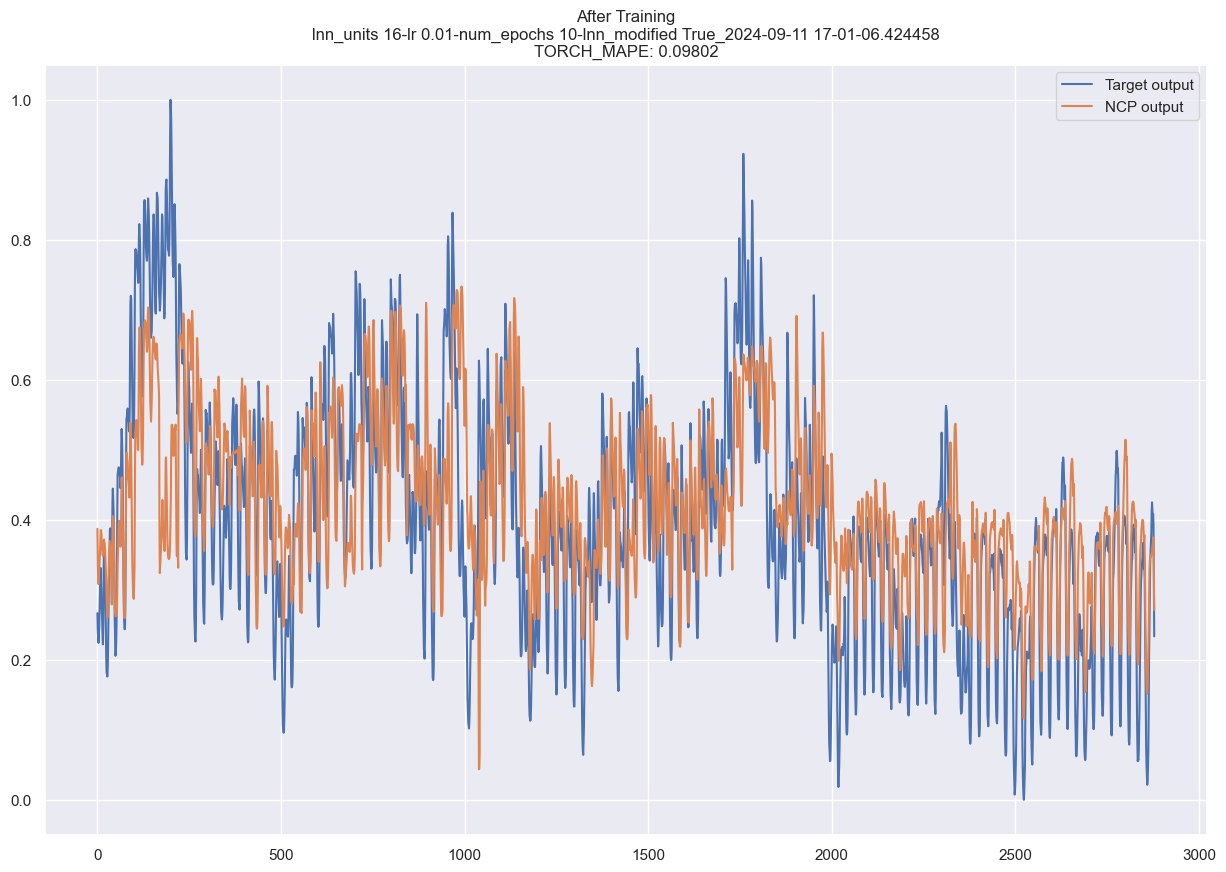

In [51]:
for key, value in prediction.items():
    if "error" in value:
        continue 

    value = prediction[key].squeeze(0).squeeze(1)
    error_torch = round(mapes[key], 5)

    name = " ".join(key.split("/")[1].replace(".ckpt", "").replace("model-", "").split("=")) + "\n" + "TORCH_MAPE: " + str(error_torch)

    sns.set_theme()
    plt.figure(figsize=(15, 10))
    plt.plot(y_features.squeeze(1), label="Target output")
    plt.plot(value, label="NCP output")

    plt.title(f"After Training\n{name}")
    plt.legend(loc="upper right")

Text(0.5, 1.0, 'Training Loss of a LNN by Epoch')

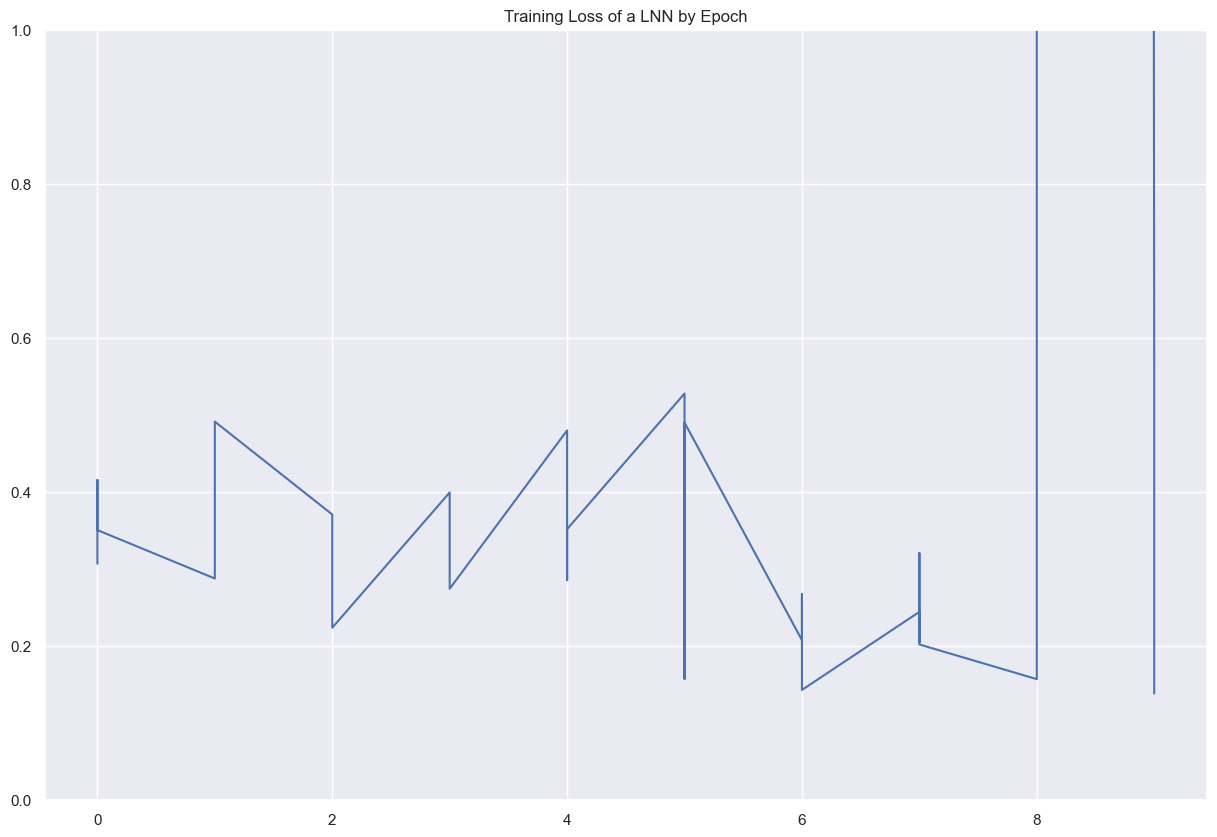

In [21]:
# plot training history
d = pd.read_csv("log/lightning_logs/version_6/metrics.csv")

sns.set_theme()
plt.figure(figsize=(15, 10))
plt.plot(d["epoch"], d["train_loss"], label="Training Loss")
plt.ylim([0, 1])

plt.title(f"Training Loss of a LNN by Epoch")